### 0. Data Loading

프로젝트 폴더에서 데이터를 불러온다 

In [1]:
import re
import pandas as pd
import numpy as np 
import json

dataOutPath='./data_out/'
File = 'train_all.csv'
#testFile = 'FDOT-clean.csv'

Input = pd.read_csv(dataOutPath+File)
#testInput = pd.read_csv(dataOutPath+testFile)  



In [2]:
test_data = Input['clauses'][:414]
test_label = Input['label'][:414]

train_data = Input['clauses'][415:]
train_label = Input['label'][415:]

train_data_df = pd.DataFrame(data = {"clauses": train_data, "label":train_label})
train_data_df.to_csv(dataOutPath+'train_data.csv')

test_data_df = pd.DataFrame(data = {"clauses": test_data, "label":test_label})
test_data_df.to_csv(dataOutPath+'test_data.csv')

In [3]:
sentences =[]
for clause in train_data:
    sentences.append(clause.split())

test_sent=[]
for clause in test_data:
    test_sent.append(clause.split())

 ### word2Vec - vectorizing hyperparameter

- num_features: 각 단어에 대해 임베딩된 벡터의 차원 
- min_word_count: 적은 빈도수의 단어는 제거하기위한 최소 단어 수 
- num_workers: 학습 프로세스 수 
- context: 워드투벡 수행시 컨텍스트 위도우 크기 지정 
- downsampling: 다운샘플링 비율 


In [4]:
# word2Vec - vectorizing hyperparameter 

num_features = 1000
min_word_count=10
num_workers=4
context=2
downsampling=1e-3


In [5]:
import logging  

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level= logging.INFO)

In [6]:
from gensim.models import word2vec
print("training model...")
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
                          size= num_features, 
                          min_count=min_word_count, 
                          window= context, 
                          sg=1,
                          sample = downsampling)

2019-11-26 23:33:25,931 : INFO : 'pattern' package not found; tag filters are not available for English
2019-11-26 23:33:25,955 : INFO : collecting all words and their counts
2019-11-26 23:33:25,956 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-11-26 23:33:25,967 : INFO : collected 2139 word types from a corpus of 24305 raw words and 1659 sentences
2019-11-26 23:33:25,968 : INFO : Loading a fresh vocabulary
2019-11-26 23:33:25,974 : INFO : effective_min_count=10 retains 507 unique words (23% of original 2139, drops 1632)
2019-11-26 23:33:25,976 : INFO : effective_min_count=10 leaves 19700 word corpus (81% of original 24305, drops 4605)
2019-11-26 23:33:25,983 : INFO : deleting the raw counts dictionary of 2139 items
2019-11-26 23:33:25,986 : INFO : sample=0.001 downsamples 93 most-common words
2019-11-26 23:33:25,987 : INFO : downsampling leaves estimated 14896 word corpus (75.6% of prior 19700)
2019-11-26 23:33:25,992 : INFO : estimated required memor

training model...



2019-11-26 23:33:26,190 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-26 23:33:26,217 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-26 23:33:26,224 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-26 23:33:26,224 : INFO : EPOCH - 2 : training on 24305 raw words (14897 effective words) took 0.1s, 172167 effective words/s
2019-11-26 23:33:26,235 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-11-26 23:33:26,276 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-26 23:33:26,308 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-26 23:33:26,312 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-26 23:33:26,313 : INFO : EPOCH - 3 : training on 24305 raw words (14908 effective words) took 0.1s, 178596 effective words/s
2019-11-26 23:33:26,326 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-

In [7]:
dataOutPath='./data_out/wvModels/'
model_name = '1126-train-wvModel'
model.save(dataOutPath+model_name)

2019-11-26 23:33:40,764 : INFO : saving Word2Vec object under ./data_out/wvModels/1126-train-wvModel, separately None
2019-11-26 23:33:40,766 : INFO : not storing attribute vectors_norm
2019-11-26 23:33:40,767 : INFO : not storing attribute cum_table
C:\Users\user\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-11-26 23:33:40,836 : INFO : saved ./data_out/wvModels/1126-train-wvModel


In [8]:
model

In [9]:
def make_feature_vec(clauses, model, num_features):
    feature_vec = np.zeros((num_features, ), dtype='float32')
    nwords = 0.
    index2word_set = set(model.wv.index2word)
    
    for word in clauses:
        if word in index2word_set:
            nwords = nwords +1.
            feature_vec = np.add(feature_vec, model[word])
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec

In [10]:
def get_avg_feature_vec(sentences, model, num_features):
    
    clauses_feature_vecs = np.zeros((len(sentences), num_features), dtype='float32')
    
    for i, clauses in enumerate(sentences):
        clauses_feature_vecs[i] = make_feature_vec(clauses, model, num_features)
    
    return clauses_feature_vecs

In [11]:
training_vec = get_avg_feature_vec(sentences, model,num_features)
test_vec = get_avg_feature_vec(test_sent,model, num_features)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [12]:
training_vec

array([[-1.8672199e-03, -2.0716395e-04,  8.1261940e-02, ...,
         2.1132234e-02, -1.1783892e-02, -3.0656539e-02],
       [-1.8930067e-03, -1.4160702e-04,  7.8604855e-02, ...,
         2.0613899e-02, -1.1495780e-02, -2.9127987e-02],
       [-1.7806385e-03, -6.4423139e-04,  8.0798224e-02, ...,
         2.0886796e-02, -1.1806290e-02, -3.0085692e-02],
       ...,
       [-1.4902474e-03,  5.9511065e-05,  8.0915585e-02, ...,
         2.1244293e-02, -1.2060645e-02, -3.0674154e-02],
       [-1.7335260e-03, -6.0064491e-04,  7.6889098e-02, ...,
         1.9991465e-02, -1.1061103e-02, -2.9178079e-02],
       [-1.6983390e-03, -3.5128242e-04,  7.3053911e-02, ...,
         1.9096652e-02, -1.0670877e-02, -2.7415082e-02]], dtype=float32)

### 3. 훈련데이터와 검증데이터 나누기

전체 훈련데이터를  t_size 비율만큼 훈련:검증 데이터로 나눈다. 
sklearn의 train_test_split 함수를 사용해서 자동으로 분할한다. 

In [14]:
from sklearn.model_selection import train_test_split

t_size=0.2 
r_seed=23

train_cl, eval_cl, train_lb, eval_lb = train_test_split(training_vec, train_label, test_size=t_size, random_state=r_seed )

train_cl.shape

(1327, 1000)

### 4. 랜덤포레스트 분류

- RandomForestClassifier 는 sklearn의 ensemble  라이브러리에서 제공한다. 
- forest라는 이름으로 분류기 객체를 생성하고, n_estimators 변수로 결정트리의 개수를 지정한다. 
- forest.fit 함수의 인자로 훈련 데이터와 레이블을 주입한다. 
- 검증데이터셋 (eval_cl, eval_lb)로 분류정확도를 측정한다. 


In [15]:
from sklearn.ensemble import RandomForestClassifier 

forest = RandomForestClassifier(n_estimators=100)

forest.fit(train_cl, train_lb)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
print("Accuracy of training: %f" % forest.score(train_cl, train_lb))
print("Accuracy: %f" % forest.score(eval_cl, eval_lb))

Accuracy of training: 1.000000
Accuracy: 0.698795


### 4.1 분류결과 
- n_estimators =n 일때, n 값이 커질수록 정확도가 향상됨을 알 수 있다. 
- n=100 일때 accuracy = 95% 달성 

- lema 보다 stemming 했을때 더 정확도가 높게 나옴 

In [17]:
from sklearn.metrics import confusion_matrix
y_pred = forest.predict(eval_cl)
cm = confusion_matrix(eval_lb, y_pred)
cm

array([[ 70,  56],
       [ 44, 162]], dtype=int64)

Text(69,0.5,'Truth')

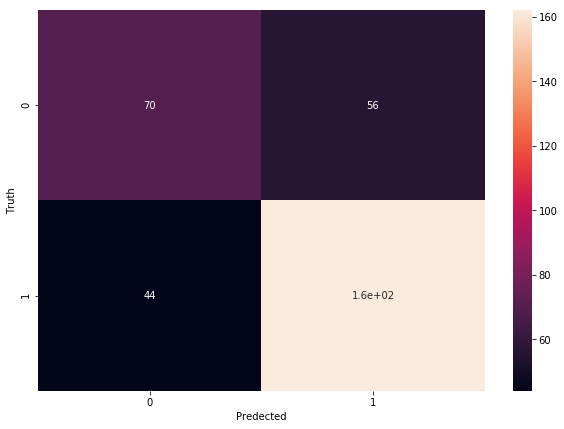

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot = True)
plt.xlabel('Predected')
plt.ylabel('Truth')

In [19]:
import os 
# 테스트 데이터 파일에 쓰기 -

output_PATH='./data_out/results/'

if not os.path.exists(output_PATH):
    os.makedirs(output_PATH)
    
# 위에서 만든 랜덤 포레스트 분류기를 통해 예측값을 가져온다.
result = forest.predict(test_vec)

# 판다스 데이터 프레임을 통해 데이터를 구성해서 output에 넣는다.
output = pd.DataFrame( data={"label": test_label ,  "predict": result} )

# 이제 csv파일로 만든다.
output.to_csv(output_PATH + "w2v-predict-test.csv", index=False, quoting=3 )